## Import libraries, read files and remove useless rows

In [2]:
# import libraries
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
from collections import Counter
import string

# Read the csv file
df = pd.read_csv('data.csv')

# Remove unlabelled samples
df = df[df['label']!="unsup"]

# Data cleaning and preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ',x))
df['review'] = df['review'].apply(lambda x: x.lower())
df['review'] = df['review'].apply(lambda x: x.split())


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\manho\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Naive Bayes Classifier by scratch

#### Functions to calculate the logarithm of probaility of single word

In [3]:
def word_log_prob(word, k):
    word = word.lower()
    if word in distinct_words_frequency:
        prob_given_pos= (pos_words_frequency.get(word,0)+1*k / (number_pos_words+V*k))
        prob_given_neg = (neg_words_frequency.get(word,0)+1*k / (number_neg_words+V*k)) 
        return np.log(prob_given_pos/prob_given_neg)
    else:
        return(0)

#### Functions to calculate the logarithm of probaility of whole review

In [4]:
def review_log_prob(review, k):
    review = review.lower().split(" ")
    prob_product = logprior
    for word in review:
        prob_product+= word_log_prob(word, k)
    return prob_product

#### Functions to calculate the F1 score

In [5]:
def Naives_Bayes_F1(k):
    
    global distinct_words_frequency
    global V
    global pos_words_frequency
    global neg_words_frequency
    global number_pos_words
    global number_neg_words
    global number_pos_reviews
    global number_neg_reviews
    global logprior
    
    # Create a dictionary to store the frequency of distinct words
    distinct_words_frequency = Counter(" ".join(df_train['new_review'].values.tolist()).split(" "))
    V = len(distinct_words_frequency.items())
    
    # Create dictionaries to store frequency of both positive words and negative words
    pos_words_frequency = Counter(" ".join(df_train.loc[df_train.label=='pos']['new_review'].values.tolist()).split(" ")) 
    neg_words_frequency = Counter(" ".join(df_train.loc[df_train.label=='neg']['new_review'].values.tolist()).split(" ")) 
    
    # Get the number of distinct positive words and negative words
    number_pos_words = len(pos_words_frequency.items()) 
    number_neg_words = len(neg_words_frequency.items()) 
    
    # Get the number of positive and negative reviews in train data
    number_pos_reviews = sum(df_train.label=='pos')
    number_neg_reviews = sum(df_train.label=='neg')
    
    logprior = np.log(number_pos_reviews/number_neg_reviews)
    
    df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
    df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
    df_test['result'] = (df_test['label']==df_test['cal_label'])
    
    # 4 conitions - True positive, True Negative, False Positive, False Negative
    conditions = [
    (df_test['result']==True) & (df_test['cal_label']=='pos'),
    (df_test['result']==True) & (df_test['cal_label']=='neg'),
    (df_test['result']==False) & (df_test['cal_label']=='pos'),
    (df_test['result']==False) & (df_test['cal_label']=='neg')
    ]
    values = ['true_pos', 'true_neg', 'false_pos', 'false_neg']
    df_test['condition'] = np.select(conditions, values)
    
    # Count the number of 4 conditions (each)
    true_pos = (df_test['condition']=='true_pos').sum()
    true_neg = (df_test['condition']=='true_neg').sum()
    false_pos = (df_test['condition']=='false_pos').sum()
    false_neg = (df_test['condition']=='false_neg').sum()
    
    # Calculate F1 score
    F1_score = true_pos /(true_pos + 0.5*(false_pos + false_neg))
    
    return F1_score
        

## Analysis of various factors that impact the performance

### 1st experiment:  Different types of text normalization

#### Use Lemmatization for text normalization

In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

df['new_review'] = df['review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if word.isalpha() and word not in cachedStopWords])
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

# Separate train and test data
df_train = df[df['type']=="train"]
df_test = df[df['type']=="test"]

lemma_score = Naives_Bayes_F1(1)
lemma_score

C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a co

0.7630712392578909

#### Use Porter Stemmer for text normalization

In [7]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

df['new_review'] = df['review'].apply(lambda x: [ps.stem(word) for word in x if word.isalpha() and word not in cachedStopWords])
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

# Separate train and test data
df_train = df[df['type']=="train"]
df_test = df[df['type']=="test"]

porter_stem_score = Naives_Bayes_F1(1)
porter_stem_score

C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a co

0.765013785112079

#### Use Snowball Stemmer for text normalization

In [8]:
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language='english')

df['new_review'] = df['review'].apply(lambda x: [snowball.stem(word) for word in x if word.isalpha() and word not in cachedStopWords])
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

# Separate train and test data
df_train = df[df['type']=="train"]
df_test = df[df['type']=="test"]

snowball_stem_score = Naives_Bayes_F1(1)
snowball_stem_score

C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a co

0.7640269957270077

### Compare F1 Score for each text normalization

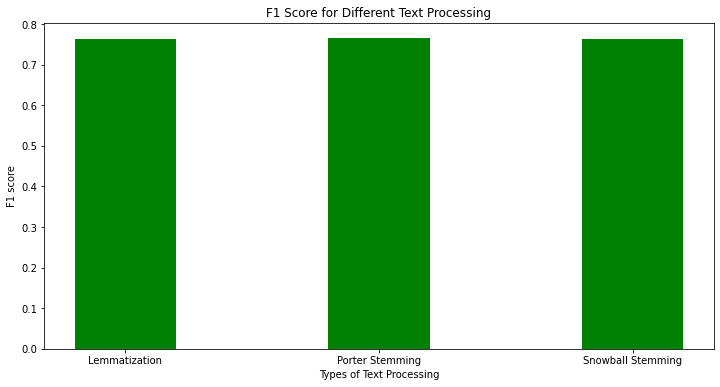

In [9]:
import matplotlib.pyplot as plt
text_processing = ['Lemmatization', 'Porter Stemming', 'Snowball Stemming']
values = [lemma_score, porter_stem_score, snowball_stem_score]


fig = plt.figure(figsize = (12, 6))
 
# Create the bar plot
plt.bar(text_processing, values, color ='green',
        width = 0.4)

plt.xlabel("Types of Text Processing")
plt.ylabel("F1 score")
plt.title("F1 Score for Different Text Processing")
plt.show()

### 2nd experiment: Different k value for k smoothing for building the Naïve Bayes Classifier

#### smoothing parameter k = 1

In [10]:
porter_stem_k1_score = porter_stem_score

#### smoothing parameter k = 2

In [11]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

df['new_review'] = df['review'].apply(lambda x: [ps.stem(word) for word in x if word.isalpha() and word not in cachedStopWords])
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

# Separate train and test data
df_train = df[df['type']=="train"]
df_test = df[df['type']=="test"]

porter_stem_k2_score = Naives_Bayes_F1(2)
porter_stem_k2_score

C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a co

0.7663364754753156

#### smoothing parameter k = 3

In [12]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

df['new_review'] = df['review'].apply(lambda x: [ps.stem(word) for word in x if word.isalpha() and word not in cachedStopWords])
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

# Separate train and test data
df_train = df[df['type']=="train"]
df_test = df[df['type']=="test"]

porter_stem_k3_score = Naives_Bayes_F1(3)
porter_stem_k3_score

C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score'] = df['new_review'].apply(lambda x: review_log_prob(x, k))
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cal_label'] = df_test['score'].apply(lambda x: 'pos' if x>0 else 'neg')
C:\Users\manho\AppData\Local\Temp/ipykernel_48788/3107627043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a co

0.7668157852692123

### Compare F1 Score for k = 1, 2, 3

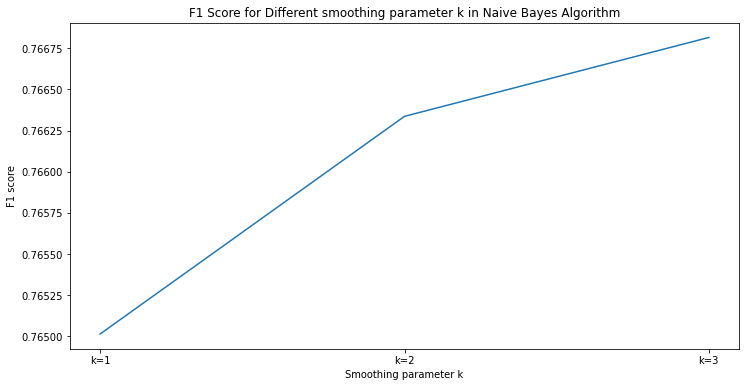

In [13]:
k_smoothing = ['k=1', 'k=2', 'k=3']
values = [porter_stem_k1_score, porter_stem_k2_score, porter_stem_k3_score]


fig = plt.figure(figsize = (12, 6))
 
# Create the bar plot
plt.plot(k_smoothing, values)

plt.xlabel("Smoothing parameter k")
plt.ylabel("F1 score")
plt.title("F1 Score for Different smoothing parameter k in Naive Bayes Algorithm")
plt.show()